# Inference and action example

This notebook demonstrates basic inference and action selection for a given generative model.  It does not consider learning, multiple factors, multiple modalities. Moreover, actions are only selected based on _extrinsic_ value, ignoring uncertainty resolution.

The notebook considers a simple `grid_world` environment with 3 x 3 states. The agent can peform one of 5 actions at each time step: `LEFT, RIGHT, UP, DOWN, STAY`. It must infer its position from observations about its location, and navigate to its preferred location. 


## Add `inferactively` module

In [1]:
import os
import sys
from pathlib import Path
path = Path(os.getcwd())
module_path = str(path.parent.parent) + '/'
sys.path.append(module_path)

## Imports

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from grid_world import GridWorldEnv
from inferactively import Categorical, softmax, generate_policies, kl_divergence

## Plotting

In [3]:
def plot_beliefs(Qs, title=""):
    values = Qs.values[:, 0]
    plt.grid(zorder=0)
    plt.bar(range(Qs.shape[0]), values, color='r', zorder=3)
    plt.xticks(range(Qs.shape[0]))
    plt.title(title)
    plt.show()
    
def plot_likelihood(A):
    ax = sns.heatmap(A.values, cmap="OrRd", linewidth=2.5)
    plt.xticks(range(A.shape[1]))
    plt.yticks(range(A.shape[0]))
    plt.title("Likelihood distribution (A)")
    plt.show()
    
def plot_empirical_prior(B):
    fig, axes = plt.subplots(3,2, figsize=(8, 10))
    actions = ['UP', 'RIGHT', 'DOWN', 'LEFT', 'STAY']
    count = 0
    for i in range(3):
        for j in range(2):
            if count >= 5:
                break
                
            g = sns.heatmap(B[count].values, cmap="OrRd", linewidth=2.5, cbar=False, ax=axes[i,j])
            g.set_title(actions[count])
            count += 1
    fig.delaxes(axes.flatten()[5])
    plt.tight_layout()
    plt.show()

## Environment

Here, we create a `grid_world` environment. We will set the `reward` location to be at state `7`.

In [4]:
REWARD_LOCATION = 7
env = GridWorldEnv()
env.set_reward_state(REWARD_LOCATION)

## Generative model

Here, we create our generative model. This is formed of a likelihood distribution $P(o_t|s_t)$, denoted `A`, and a empirical prior (transition) distribution $P(s_t|s_{t-1},a_{t-1})$, denoted `B`.

Normally, this would be hand-crafted or learned. But the for the purpose of this tutorial, we will let the environment class generate it for us.

Note that calling `remove_zeros` is not strictly neccessary, but is best practice as zeros can cause issues


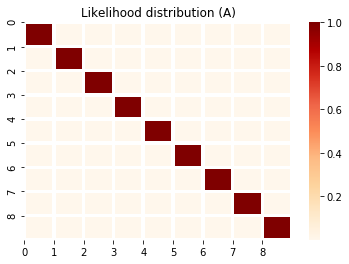

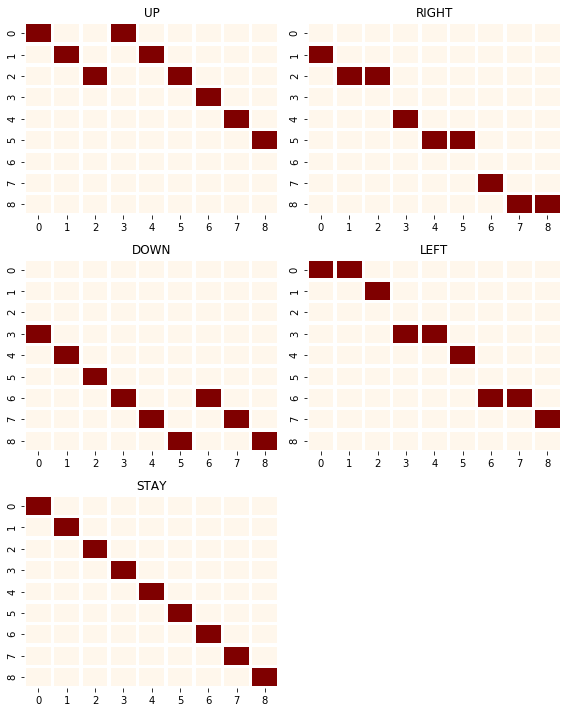

In [5]:
likelihood_matrix = env.get_likelihood_matrix()
A = Categorical(values=likelihood_matrix)
A.remove_zeros()
plot_likelihood(A)

transition_matrix = env.get_transition_matrix()
B = Categorical(values=transition_matrix)
B.remove_zeros()
plot_empirical_prior(B)

## Beliefs

Here, we setup a placeholder for the agent's beliefs about its current position in the environment

In [6]:
Qs = Categorical(dims=[env.n_states])

## Prior preferences

Here, we setup an agents _prior_ beliefs about its position in the environment. Under the active inference framework, these beleifs entail an agent's _preferences_. 

In the current context, the agent wants (i.e., expects) to be in the reward location `7`.

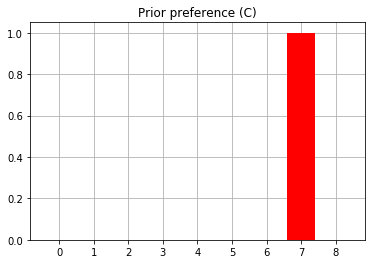

In [7]:
C = Categorical(dims=[env.n_states])
C[REWARD_LOCATION] = 1.
plot_beliefs(C, title="Prior preference (C)")

## Evaluate policy 

This helper function we evaluate the negative expected free energy for a given policy $-G(\pi)$


In [8]:
def evaluate_policy(policy, Qs, A, B, C):
    # store expected free energy
    G = 0
    
    # create copy of our state
    Qs = Qs.copy()
        
    # loop over policy
    for t in range(len(policy)):

        # get action
        u = int(policy[t])

        # work out expected state
        Qs = B[u].dot(Qs)

        # work out expected observations
        Qo = A.dot(Qs)

        # get entropy
        H = A.entropy()

        # get predicted divergence and uncertainty and novelty
        divergence = kl_divergence(Qo, C)
        # TODO: this is not ideal...
        uncertainty = H.dot(Qs).values
        
        G += (divergence + uncertainty)
    return -G

## Infer action

This helper function will infer the most likely action

In [9]:
def infer_action(Qs, A, B, C, n_actions, policy_len):
    
    # this function generates all possible combinations of policies
    policies = generate_policies(n_actions, policy_len)
    n_policies = len(policies)

    # negative expected free energy
    neg_G = np.zeros([n_policies, 1])

    for i, policy in enumerate(policies):
        neg_G[i] = evaluate_policy(policy, Qs, A, B, C)

    # get distribution over policies
    Q_pi = softmax(neg_G)

    # probabilites of control states
    Qu = Categorical(dims=n_actions)

    # sum probabilites of controls 
    for i, policy in enumerate(policies):
        # control state specified by policy
        u = int(policy[0])
        # add probability of policy
        Qu[u] += Q_pi[i]

    # normalize
    Qu.normalize()

    # sample control
    u = Qu.sample()

    return u

## Main loop

Time step 0
o  x  o
o  o  o
o  R  o



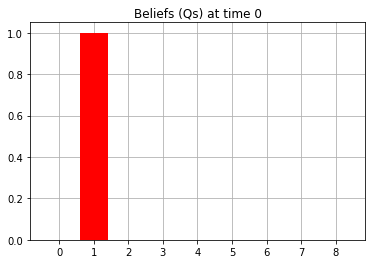

Time step 1
o  o  o
o  x  o
o  R  o



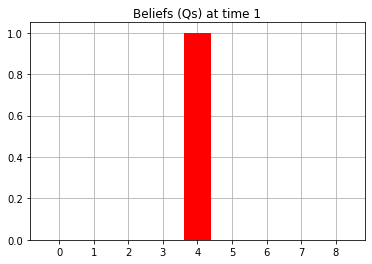

Time step 2
o  o  o
o  o  o
o  x  o



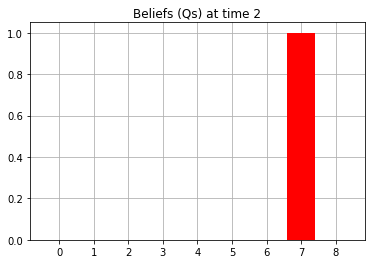

Time step 3
o  o  o
o  o  o
o  x  o



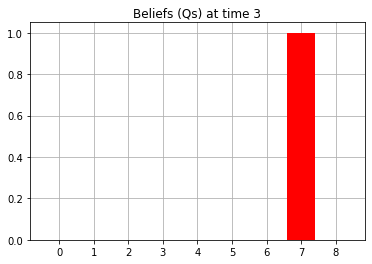

Time step 4
o  o  o
o  o  o
o  x  o



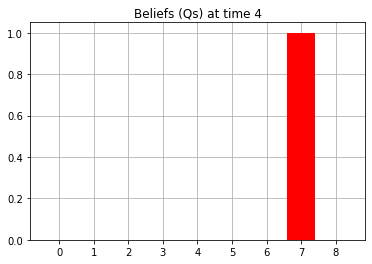

Time step 5
o  o  o
o  o  o
o  x  o



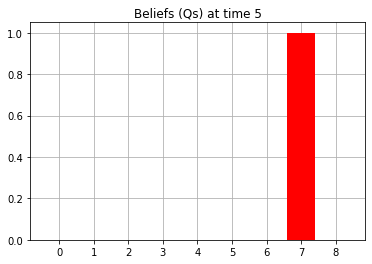

Time step 6
o  o  o
o  o  o
o  x  o



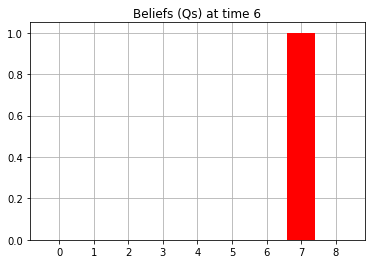

Time step 7
o  o  o
o  o  o
o  x  o



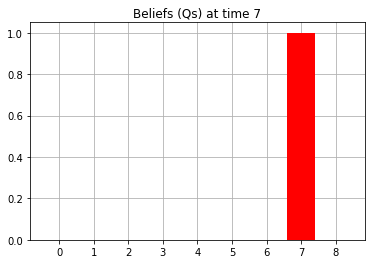

Time step 8
o  o  o
o  o  o
o  x  o



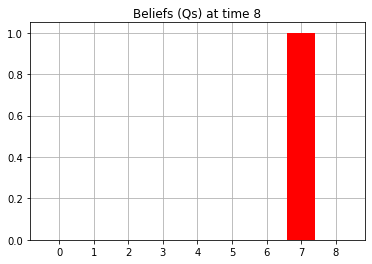

Time step 9
o  o  o
o  o  o
o  x  o



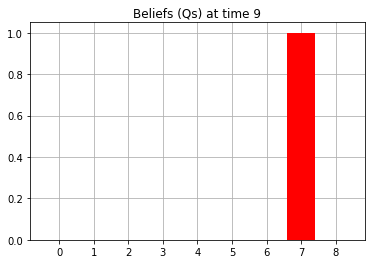

In [11]:
# number of time steps
T = 10

# number of actions
n_actions = env.n_actions

# length of policies we consider
policy_len = 4

# set initial state
env.set_initial_state(0)

# reset environment
o = env.reset()

# infer initial state
Qs = softmax(A[o, :].log())

# loop over time
for t in range(T):

    # random action
    a = infer_action(Qs, A, B, C, n_actions, policy_len)

    # perform action
    o, r = env.step(a)

    # infer new hidden state
    Qs = softmax(A[o,:].log() + B[a].dot(Qs).log())
    
    # print information
    print("Time step {}".format(t))
    env.render()
    plot_beliefs(Qs, "Beliefs (Qs) at time {}".format(t))